# 2-halo term

In this example, we use the tools provided in `profiley` together with the Core Cosmology Library to obtain a 2-halo term for the lensing convergence.

**NOTE** I think if I want to calculate the 1-halo term in comoving coordinates I also need to use the comoving background density - not sure what that should be for critical density though? One way around this for the time being is to implement this example in angular coordinates so I can convert each piece using proper/comoving coordinates internally.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyccl as ccl
from scipy.interpolate import interp1d

from profiley.nfw import NFW
from profiley.helpers.lss import power2xi, xi2sigma

Let's probe a range of masses at fixed redshift. For simplicity they will all have the same concentration, $c=4$. `profiley` can handle numpy arrays natively (to probe a grid of two parameters, say mass and redshift, the user must make sure that parameters have the appropriate shape; `profiley` will not edit the shapes of the arguments). To ensure consistency we should also define the overdensity we are considering. Finally, because we'll be looking at the 2-halo term we will do all calculations in comoving coordinates.

In [2]:
m = np.logspace(14, 15, 5)
z = 0.5
c = 4
delta = 500
background = 'critical'

In [3]:
nfw = NFW(m, c, z, overdensity=delta, background=background[0], frame='comoving')

We've covered the one-halo term in the `nfw_single` example. We need to give it the radii at which we are measuring it and, in the case of the convergence, the source redshift. Let's say we are measuring lensing on the CMB, so $z_s=1100$. Since we are going to add a 2-halo term, the convergence has an additional $(1+z)^2$ factor incorporated (which is actually a rescaling $\Sigma_\mathrm{cr}\rightarrow\Sigma_\mathrm{cr}/(1+z)^2$).

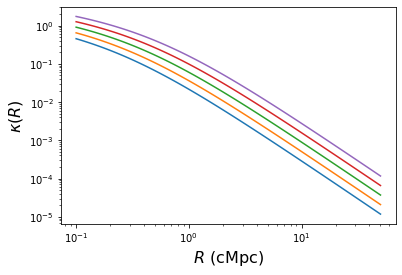

In [4]:
R = np.logspace(-1, 1.7, 100)
zs = 1100
kappa_1h = nfw.convergence(R, zs)

plt.loglog(R, kappa_1h)
plt.xlabel('$R$ (cMpc)', fontsize=16)
plt.ylabel(r'$\kappa(R)$', fontsize=16);

Now for the 2-halo term. Let's start by setting the cosmology within `CCL`

In [5]:
h = 0.7
Om = 0.3
Ob = 0.045
As = 2.1e-9
ns = 0.96
cosmo = ccl.Cosmology(Omega_c=Om-Ob, Omega_b=Ob, h=h, A_s=As, n_s=ns)

Now we can calculate the linear matter power spectrum

In [6]:
%%time
k = np.logspace(-15, 15, 10000)
Pk = ccl.linear_matter_power(cosmo, k, 1/(1+z))
Pk.shape

CPU times: user 3.41 s, sys: 12.2 ms, total: 3.43 s
Wall time: 475 ms


(10000,)

and multiply by a halo bias to get the galaxy-matter power spectrum. Doing this requires defining the mass in `CCL`.

In [7]:
%%time
mdef = ccl.halos.MassDef(delta, background)
bias = ccl.halos.HaloBiasTinker10(cosmo, mass_def=mdef)
bh = bias.get_halo_bias(cosmo, m, 1/(1+z))
Pgm = bh[:,None] * Pk
Pgm.shape

CPU times: user 85.4 ms, sys: 988 µs, total: 86.3 ms
Wall time: 86 ms


(5, 10000)

`profiley` has a helper function called `power2xi` (see import above) to convert to a correlation function. Be sure that the radii used cover a wide enough range to avoid problems when turning this into a surface density. (Credit goes to Andrej Dvornik for writing this function, used in `profiley` with permission.) Note that `power2xi` takes an `interp1d` object in natural-log space; running `power2xi` over multiple redshifts can only be accomplished by looping over it.

In [8]:
%%time
r_xi = np.logspace(-3, 4, 100)
xi = np.zeros((m.size,r_xi.size))
for i, Pgm_i in enumerate(Pgm):
    lnPgm_lnk = interp1d(np.log(k), np.log(Pgm_i))
    xi[i] = power2xi(lnPgm_lnk, r_xi)
xi.shape

CPU times: user 191 ms, sys: 959 µs, total: 192 ms
Wall time: 190 ms


(5, 100)

We now come to the slow part: projecting the correlation function into a surface density. Be sure to try this out before running in "production mode", including saving it to a file so you don't need to run this multiple times to get the same outcome. We will use the same distances we used for the 1-halo term to calculate the 2-halo term.

Note that because the linear matter power spectrum is in comoving units, we need to pass comoving radii here, hence the $(1+z)$ factor. Note also that for the time being the output of `xi2sigma` has to be transposed to be consistent with the 1-halo calculations. For the same reason, we calculate the background density at $z=0$ which is equal to the comoving matter density at all redshifts.

In [9]:
rho_m = ccl.background.rho_x(cosmo, 1, 'matter')

In [10]:
%%time
sigma_2h = xi2sigma(R, r_xi, xi, rho_m).T
sigma_2h.shape

/home/cristobal/anaconda3/envs/cmb/lib/python3.8/site-packages/profiley-1.1.0b3-py3.8.egg/profiley/helpers/lss.py:167: IntegrationWarning: The integral is probably divergent, or slowly convergent.


CPU times: user 8.21 s, sys: 26.8 ms, total: 8.24 s
Wall time: 8.52 s


(100, 5)

Note that it took 10 seconds to calculate sigma 5 times, i.e., roughly two seconds per instance! For a full halo model fitting analysis - let alone an MCMC - where you might need to calculate this thousands of times, it can add up!

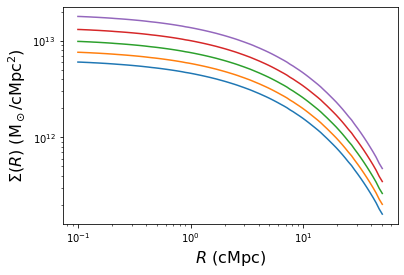

In [11]:
plt.loglog(R, sigma_2h)
plt.xlabel('$R$ (cMpc)', fontsize=16)
plt.ylabel(r'$\Sigma(R)$ (M$_\odot$/cMpc$^2$)', fontsize=16);

In order to turn this into a covergence we need to divide by the critical surface density. Remember again that we are calculating the 2-halo term in comoving coordinates, so there is an extra $(1+z)^2$ factor:

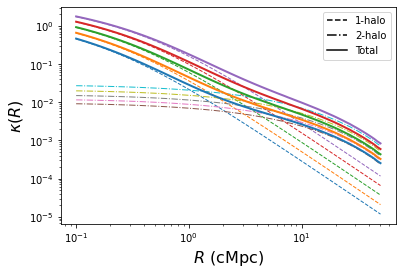

In [12]:
kappa_2h = sigma_2h / nfw.sigma_crit(zs)

plt.loglog(R, kappa_1h, '--', lw=1)
plt.plot(R, kappa_2h, '-.', lw=1)
plt.plot(R, kappa_1h+kappa_2h, '-', lw=2)
plt.plot([], [], 'k--', label='1-halo')
plt.plot([], [], 'k-.', label='2-halo')
plt.plot([], [], 'k-', label='Total')
plt.legend()
plt.xlabel('$R$ (cMpc)', fontsize=16)
plt.ylabel(r'$\kappa(R)$', fontsize=16);